In [2]:
import json
import pandas as pd
import cv2
import numpy as np
from enum import Enum, auto
import sys
import torch
import matplotlib.pyplot as plt


sys.path.append("../Skin_segmentation")
sys.path.append('../../Models')

from Skindetector import *
from rPPGNet import rPPGNet

with open('../../Data/json_structure') as json_file:
    data = json.load(json_file)

def moving_average(series, window_size=5):
            # Convert array of integers to pandas series 
            # Get the window of series 
            # of observations of specified window size 
            windows = series.rolling(window_size) 

            # Create a series of moving 
            # averages of each window 
            moving_averages = windows.mean() 

            # Convert pandas series back to list 
            moving_averages_list = moving_averages.tolist() 
            final_list = moving_averages_list

            return final_list


root_dir = "/work3/s174159/data/"
video_file = root_dir + "00/02/c920-1.avi"
bb_file = root_dir + "bbox/00/02/c920-1.face"
ecg_path = root_dir + "00/02/viatom-raw.csv"
index_path = root_dir + "00/02/c920.csv"

bb_data =  pd.read_csv(bb_file, sep=" ", header=None, names=["frame", "x", "y", "w", "h"]).drop("frame", axis=1)
idx = pd.read_csv(index_path, header=None, names=["timestamp", "idx_sig"])
ecg = pd.read_csv(ecg_path)

In [125]:
model = rPPGNet()
model.load_state_dict(torch.load("../../logs/Eulerian/models/run_2023-10-30_11-34-54/model.pth", map_location=torch.device('cpu')))
model.eval()

rPPGNet(
  (ConvSpa1): Sequential(
    (0): Conv3d(3, 16, kernel_size=(1, 5, 5), stride=(1, 1, 1), padding=(0, 2, 2))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ConvSpa3): Sequential(
    (0): SpatioTemporalConv(
      (spatial_conv): Conv3d(16, 57, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
      (bn): BatchNorm3d(57, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (temporal_conv): Conv3d(57, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
    )
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (ConvSpa4): Sequential(
    (0): SpatioTemporalConv(
      (spatial_conv): Conv3d(32, 72, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
      (bn): BatchNorm3d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      

In [126]:
import cv2
from IPython.display import display, Image

# Define the VideoCapture object and VideoWriter
output_file = 'output_video.mp4'
video = cv2.VideoCapture(video_file)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for the output video
out = cv2.VideoWriter(output_file, fourcc, 30, (128, 128) ) # 30 is the frames per second, (128, 128) is the frame size

display_handle = display(None, display_id=True)
i = 0

bounded_frames = []

try:
    while True:
        ret, frame = video.read()
        if not ret:  # Check if there are no more frames
            print("Finished video...")
            break  # Exit the loop if there are no more frames
        
        if i == len(data):
            i = 0
        x, y, w, h = bb_data.iloc[i].values.astype(int)
        i += 1
        frame_bb = frame[y:y + h, x:x + w]
        frame_bb = cv2.resize(frame_bb, (128, 128), interpolation=cv2.INTER_AREA)
        bounded_frames.append(np.array(frame_bb, dtype='float32'))
        #detector = SkinDetector(frame_bb)
        #detector.find_skin()
        #image, mask, skin = detector.get_resulting_images()
        
        # Save the processed frame to the output video
        #out.write(frame)
        
        #_, frame = cv2.imencode('.jpeg', frame)
        #display_handle.update(Image(data=frame.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()
    out.release()  # Release the VideoWriter
    display_handle.update(None)


None

Finished video...


In [127]:
frame_tensor = torch.tensor(np.array(bounded_frames[1:65]))
frame_tensor = torch.swapaxes(frame_tensor, 0, 3)
frame_tensor = torch.swapaxes(frame_tensor, 1, 3)

In [133]:
frame_tensor.unsqueeze(0).shape

torch.Size([1, 3, 64, 128, 128])

In [135]:
skin_map, rPPG_aux, rPPG, rPPG_SA1, rPPG_SA2, rPPG_SA3, rPPG_SA4, x_visual6464, x_visual3232 = model(frame_tensor.unsqueeze(0))

In [1]:
def moving_average(series, window_size=5):
            # Convert array of integers to pandas series 

            # Get the window of series 
            # of observations of specified window size 
            windows = series.rolling(window_size) 

            # Create a series of moving 
            # averages of each window 
            moving_averages = windows.mean() 

            # Convert pandas series back to list 
            moving_averages_list = moving_averages.tolist() 
            final_list = moving_averages_list

            return final_list

In [22]:
ecg
idx = pd.read_csv(index_path, header=None, names=["timestamp", "idx_sig"])
idx

,timestamp,idx_sig
0,1523631753577,4955
1,1523631753620,4960
2,1523631753643,4965
3,1523631753676,4970
4,1523631753707,4975
...,...,...
1795,1523631813486,12445
1796,1523631813513,12450
1797,1523631813560,12455
1798,1523631813582,12460


In [23]:
from ecgdetectors import Detectors
fs=250
detectors = Detectors(fs)
ecg = pd.read_csv(ecg_path)
ecg = ecg.groupby(by="milliseconds", as_index=False).mean()
ecg = ecg.iloc[int(idx.iloc[1].idx_sig/5):][:65*2] 
#r_peaks = detectors.two_average_detector(ecg[" ECG"])

IndexError: index 130 is out of bounds for axis 0 with size 130

In [17]:
r_peaks

[82, 329, 509, 811, 1639]

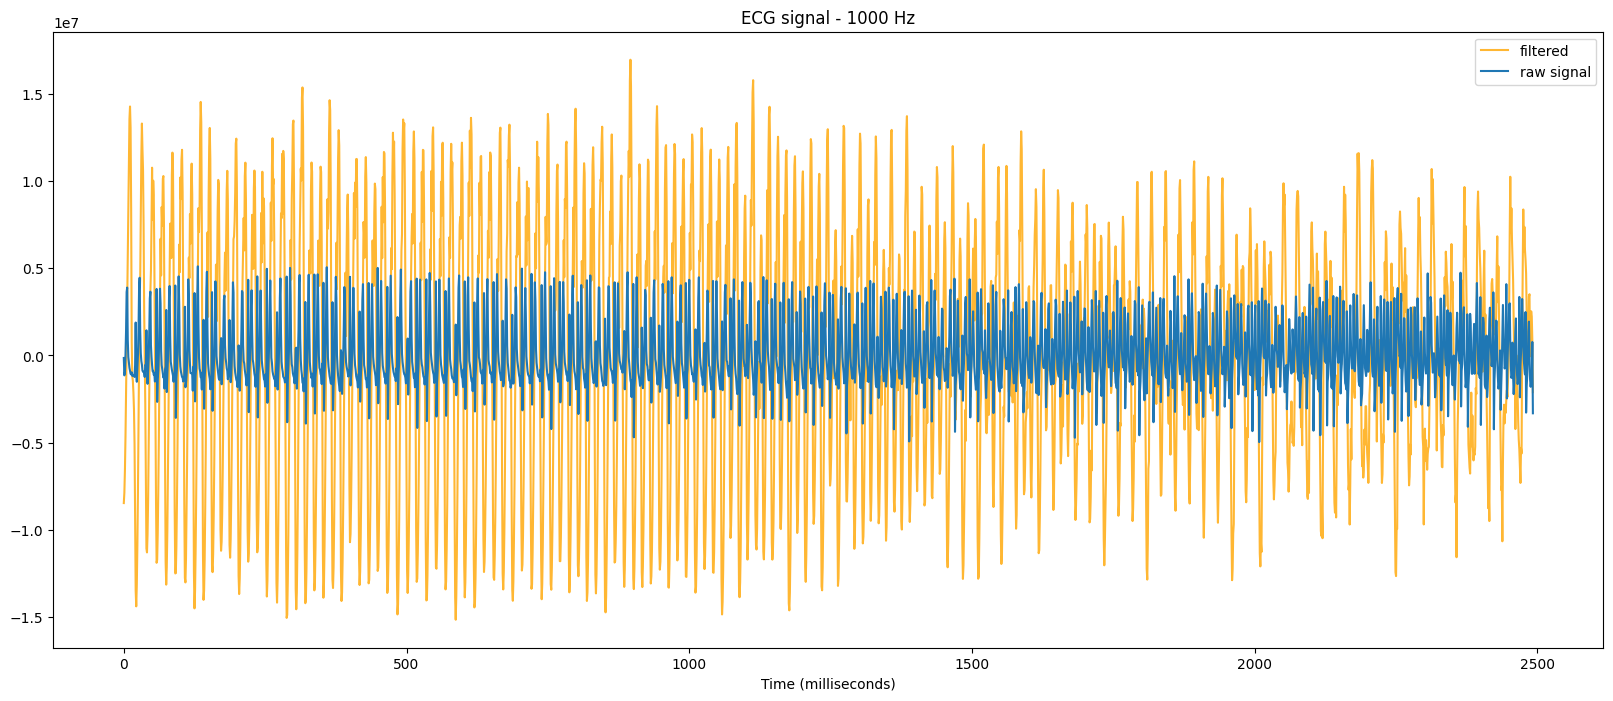

In [ ]:
# linear spaced vector between 0.5 pi and 1.5 pi 
v = np.linspace(0.5 * np.pi, 1.5 * np.pi, 15)

# create sine filter for approximating QRS feature
peak_filter = np.sin(v)

# compute cross correlation between ecg and the sine filter
ecg = pd.read_csv(ecg_path)
ecg = ecg.groupby(by="milliseconds", as_index=False).mean()
ecg_transformed = np.correlate(ecg[" ECG"], peak_filter, mode="same")
plt.figure(figsize=(20,8))
plt.title('ECG signal - 1000 Hz')
plt.plot(ecg_transformed, alpha = 0.8, c='orange')
plt.plot(ecg[" ECG"], alpha = 1)
plt.gca().legend(('filtered','raw signal'))
plt.xlabel('Time (milliseconds)')
plt.show()

In [ ]:
ecg = pd.read_csv(ecg_path)
#ecg

,milliseconds,ECG,ECG HR,PPG,PPG HR,SpO2,PI,ECG_norm,ECG_MV
992,1523629969838,144179.2,-109.0,-56.0,-1.0,-1.0,0.0,0.622159,0.599432
993,1523629969862,-3119513.6,-109.0,-56.0,-1.0,-1.0,0.0,0.268466,0.555682
994,1523629969902,65536.0,-109.0,-56.0,-1.0,-1.0,0.0,0.613636,0.564489
995,1523629969943,747110.4,-108.0,-56.0,-1.0,-1.0,0.0,0.687500,0.568182
996,1523629969982,196608.0,-108.0,-56.0,-1.0,-1.0,0.0,0.627841,0.563920
...,...,...,...,...,...,...,...,...,...
1117,1523629974824,-1743257.6,-105.0,-56.0,-1.0,-1.0,0.0,0.417614,0.590057
1118,1523629974864,13107.2,-105.0,-56.0,-1.0,-1.0,0.0,0.607955,0.565909
1119,1523629974904,707788.8,-105.0,-56.0,-1.0,-1.0,0.0,0.683239,0.584375
1120,1523629974957,550502.4,-105.0,-56.0,-1.0,-1.0,0.0,0.666193,0.600852


In [1]:
im
plt.plot(ecg[" ECG HR"])

NameError: name 'plt' is not defined

In [ ]:
import scipy


In [14]:
model_output = [0.9420, 1.0000, 0.9986, 0.9438, 0.7974, 0.5907, 0.4464, 0.4006, 0.4038,
         0.4085, 0.4105, 0.4096, 0.4125, 0.4279, 0.4473, 0.4662, 0.4787, 0.4862,
         0.4876, 0.4833, 0.4733, 0.4515, 0.3992, 0.3224, 0.2237, 0.1271, 0.0551,
         0.0119, 0.0000, 0.0172, 0.0438, 0.0643, 0.0802, 0.0916, 0.0962, 0.1023,
         0.1115, 0.1238, 0.1339, 0.1407, 0.1503, 0.1693, 0.2010, 0.2513, 0.3122,
         0.3705, 0.4194, 0.4592, 0.4903, 0.5102, 0.5169, 0.5053, 0.4876, 0.4650,
         0.4384, 0.4050, 0.3621, 0.3051, 0.2467, 0.1985, 0.1714, 0.1635, 0.1925,
         0.4493]

target = [0.2500, 0.3098, 0.3397, 0.3098, 0.2908, 0.3043, 0.3016, 0.2853, 0.2853,
         0.2853, 0.2690, 0.4810, 0.4810, 0.2636, 0.2717, 0.2989, 0.3424, 0.3288,
         0.2717, 0.2364, 0.2065, 0.1549, 0.1060, 0.1087, 0.1168, 0.1087, 0.4239,
         0.4293, 0.1277, 0.1386, 0.1576, 0.2065, 0.2364, 0.2065, 0.1793, 0.1766,
         0.1685, 0.1549, 0.1658, 0.1685, 0.1603, 0.4891, 0.4973, 0.1766, 0.1739,
         0.2011, 0.2500, 0.2772, 0.2473, 0.2147, 0.2120, 0.2011, 0.1875, 0.1984,
         0.1984, 0.1875, 0.5380, 0.5435, 0.1984, 0.2120, 0.2446, 0.2908, 0.3125,
         0.2908]
import numpy as np
model_output1 = (model_output - np.min(model_output)) / (np.max(model_output ) - np.min(model_output))
model_output2 = (model_output-np.mean(model_output)) /np.std(model_output)	

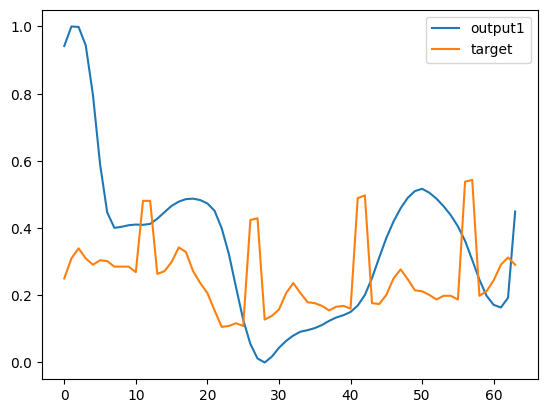

In [15]:
import matplotlib.pyplot as plt
plt.plot(model_output, label="output1")
#plt.plot(model_output2, label="output2")
plt.plot(target, label="target")
plt.legend()

In [ ]:
detectors = Detectors(fs)